In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Core: within-block overall R^2 ----------
def within_block_overall_r2(series, block_size, idx_start=64):
    """
    series: list[dict], each dict has {"step": int, "idx": int}
    block_size: e.g., 32/64/128
    idx_start: first idx (you said 64)

    Returns: overall within-block R^2 (aggregated SSE/SST across blocks)
    """
    steps = np.array([d["step"] for d in series], dtype=np.float64)
    idxs  = np.array([d["idx"]  for d in series], dtype=np.float64)

    # sort by step (not strictly needed for R^2, but stable)
    order = np.argsort(steps)
    steps = steps[order]
    idxs  = idxs[order]

    # assign blocks by idx
    block_ids = ((idxs - idx_start) // block_size).astype(np.int64)

    total_ss_res = 0.0
    total_ss_tot = 0.0

    for bid in np.unique(block_ids):
        mask = (block_ids == bid)
        s = steps[mask]
        y = idxs[mask]

        # need >=2 points and varying x
        if y.size < 2 or np.ptp(s) == 0:
            continue

        m, b = np.polyfit(s, y, deg=1)
        yhat = m * s + b

        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)

        total_ss_res += ss_res
        total_ss_tot += ss_tot

    if total_ss_tot <= 0:
        return float("nan")
    return 1.0 - (total_ss_res / total_ss_tot)


# ---------- Permutation null (shuffle within block) ----------
def within_block_perm_null(series, block_size, idx_start=64, n_perm=500, seed=0):
    """
    Builds null distribution by shuffling idx within each idx-block.
    Returns array of null R^2 values (length n_perm).
    """
    rng = np.random.default_rng(seed)

    steps = np.array([d["step"] for d in series], dtype=np.float64)
    idxs  = np.array([d["idx"]  for d in series], dtype=np.float64)
    order = np.argsort(steps)
    steps = steps[order]
    idxs  = idxs[order]

    block_ids = ((idxs - idx_start) // block_size).astype(np.int64)
    uniq = np.unique(block_ids)

    # pre-collect indices per block
    block_to_inds = {bid: np.where(block_ids == bid)[0] for bid in uniq}

    null = np.empty(n_perm, dtype=np.float64)
    for i in range(n_perm):
        idxs_perm = idxs.copy()
        for bid, inds in block_to_inds.items():
            if inds.size >= 2:
                idxs_perm[inds] = rng.permutation(idxs_perm[inds])
        # build perm series dicts for reuse of the same R^2 routine
        perm_series = [{"step": int(s), "idx": float(y)} for s, y in zip(steps, idxs_perm)]
        null[i] = within_block_overall_r2(perm_series, block_size, idx_start=idx_start)

    return null


def perm_zscore(obs, null):
    mu = np.nanmean(null)
    sd = np.nanstd(null, ddof=1)
    if not np.isfinite(obs) or sd <= 0:
        return float("nan")
    return float((obs - mu) / sd)

def perm_pvalue(obs, null):
    # one-sided: P(null >= obs)
    if not np.isfinite(obs):
        return float("nan")
    null = null[np.isfinite(null)]
    if null.size == 0:
        return float("nan")
    return float((np.sum(null >= obs) + 1) / (null.size + 1))


# ---------- Robust within-group normalization (no permutations) ----------
def robust_z_within_group(values):
    v = np.asarray(values, dtype=np.float64)
    med = np.nanmedian(v)
    mad = np.nanmedian(np.abs(v - med))
    denom = 1.4826 * mad  # ~std if normal
    if denom <= 0:
        return np.full_like(v, np.nan, dtype=np.float64)
    return (v - med) / denom


# ---------- Plot: normed jitter ----------
def plot_r2_jitter_normed(
    data_by_block_size,
    *,
    idx_start=64,
    jitter=2.0,
    norm="perm_z",          # "none" | "perm_z" | "perm_p" | "robust_z"
    n_perm=500,
    seed=0,
    show_mean=True,
    title=None,
):
    """
    data_by_block_size: dict like
        {
          32:  [seriesA, seriesB, ...],
          64:  [seriesC, seriesD, ...],
          128: [seriesE, ...],
        }
    where each series is a list of dicts: [{"step":..., "idx":...}, ...]

    Produces jitter scatter at x=block_size.
    """

    rng = np.random.default_rng(seed)
    block_sizes = sorted(data_by_block_size.keys())

    # compute observed within-block R^2 per series
    obs_by_bs = {}
    for bs in block_sizes:
        obs_list = []
        for series in data_by_block_size[bs]:
            obs_list.append(within_block_overall_r2(series, bs, idx_start=idx_start))
        obs_by_bs[bs] = np.array(obs_list, dtype=np.float64)

    # normalize
    y_by_bs = {}
    ylabel = "within-block R²"
    if norm == "none":
        y_by_bs = obs_by_bs
        ylabel = "within-block R²"
    elif norm in ("perm_z", "perm_p"):
        for bs in block_sizes:
            ys = []
            for i, series in enumerate(data_by_block_size[bs]):
                obs = obs_by_bs[bs][i]
                null = within_block_perm_null(
                    series, bs, idx_start=idx_start, n_perm=n_perm, seed=int(rng.integers(1_000_000_000))
                )
                if norm == "perm_z":
                    ys.append(perm_zscore(obs, null))
                else:
                    ys.append(perm_pvalue(obs, null))
            y_by_bs[bs] = np.array(ys, dtype=np.float64)
        ylabel = "perm-z (within-block)" if norm == "perm_z" else "perm p-value (within-block)"
    elif norm == "robust_z":
        for bs in block_sizes:
            y_by_bs[bs] = robust_z_within_group(obs_by_bs[bs])
        ylabel = "robust z-score (within-block R²)"
    else:
        raise ValueError("norm must be one of: 'none', 'perm_z', 'perm_p', 'robust_z'")

    if title is None:
        title = f"R² comparison (norm={norm})"

    # plot
    plt.figure(figsize=(8, 5))
    for bs in block_sizes:
        y = y_by_bs[bs]
        y = y[np.isfinite(y)]
        if y.size == 0:
            continue

        xj = bs + rng.uniform(-jitter, jitter, size=y.size)
        plt.scatter(xj, y, alpha=0.85)

        if show_mean:
            plt.scatter([bs], [np.mean(y)], marker="x", s=120)

    plt.xticks(block_sizes, [str(int(v)) for v in block_sizes])
    plt.xlabel("block size")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



In [2]:
import os
from datasets import Dataset
from collections import defaultdict

folder_base = 'kv_states_20260219'
dict_line_logs = defaultdict(list)

for name_file in os.listdir(folder_base):
    if name_file[0] == '.':
        continue
    # end

    path_file = os.path.join(folder_base, name_file)
    ds = Dataset.load_from_disk(path_file)

    for step, item in enumerate(list(ds['idx_token'])):
        dict_log = {}
        dict_log['step'] = step
        dict_log['idx'] = item[0]
        dict_line_logs[name_file.split('.')[0]].append(dict_log)
    # end
# end

list_lines_illustrate_32 = [dict_line_logs[key] for key in dict_line_logs.keys() if key.split('-')[-1] == '32']
list_lines_illustrate_64 = [dict_line_logs[key] for key in dict_line_logs.keys() if key.split('-')[-1] == '64']
list_lines_illustrate_128 = [dict_line_logs[key] for key in dict_line_logs.keys() if key.split('-')[-1] == '128']

/home/exx/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


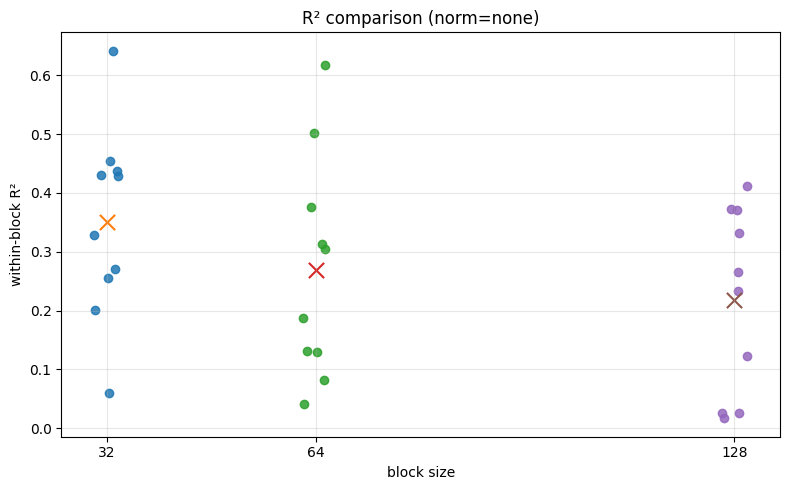

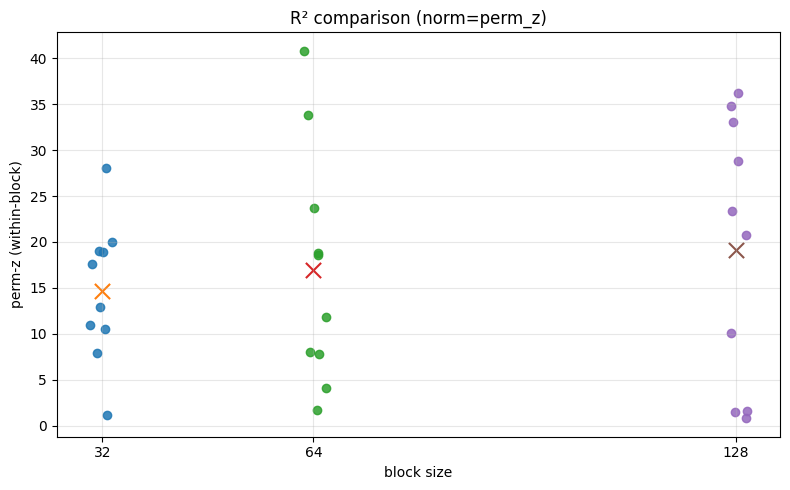

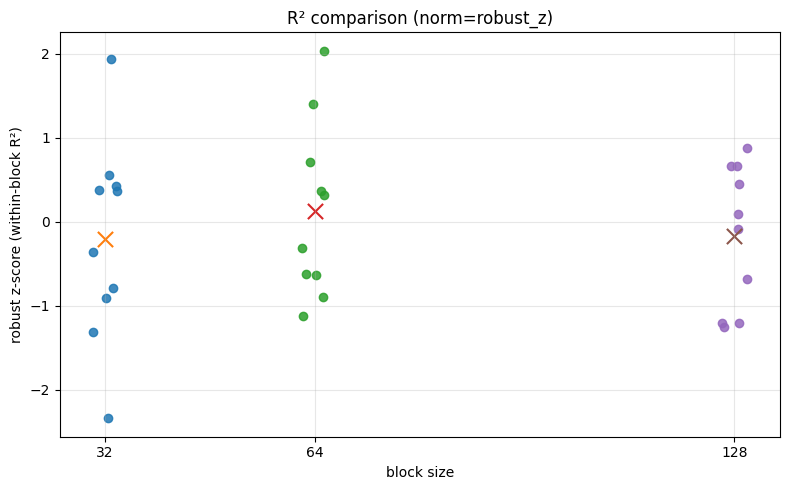

In [3]:

# ------------------ Example usage ------------------
data_by_block_size = {
    32:  list_lines_illustrate_32,
    64:  list_lines_illustrate_64,
    128: list_lines_illustrate_128,
}

plot_r2_jitter_normed(data_by_block_size, norm="none")
plot_r2_jitter_normed(data_by_block_size, norm="perm_z", n_perm=1000)
plot_r2_jitter_normed(data_by_block_size, norm="robust_z")
